In [6]:
import pickle
import numpy as np
import time,sys,glob,os
import pandas as pd
import scipy.ndimage as ndi
import cc3d
import cv2
import open3d as o3d

from skimage import color, morphology, measure
from skimage.transform import downscale_local_mean
from skimage.registration import phase_cross_correlation

from scipy.stats import zscore
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from functions.cellregister import *
from functions.iterive_non_rigid import *
# from functions.tiling import *
import functions.tiling as tiling  # 如果tiling.py在同一个functions目录下

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 参数

In [22]:
add_edge = np.array((10,100,100))
outputshape = add_edge*2

max_iteration = 100  # shape ICP max iteration 
thre = 8 # shape ICP parametrs
ds_sz = 5 # shape ICP downsample size
with_scaling = True # shape ICP learn the scaling 
ds_sz_aff=3 # NCC downsample size
vec_ds = 3 # vector field downsample size. 
max_correspondence_distance = 50

### 加载

In [8]:
def load_and_extract_matches(lut_path):
    """Load LUT and extract matched coordinates and images"""
    with open(lut_path, 'rb') as f:
        lookup_table = pickle.load(f)
    
    # Get images
    invivo_image = lookup_table['in_vivo']['Transformed']
    exvivo_image = lookup_table['exvivo_GCAMP']['Transformed']
    
    # Extract matched coordinates
    in_vivo_coords = []
    ex_vivo_coords = []
    
    for ex_cell in lookup_table['exvivo_GCAMP']['cells']:
        if 'in_vivo_id' in ex_cell:
            # Find matching in vivo cell
            in_vivo_cell = next(cell for cell in lookup_table['in_vivo']['cells'] 
                               if cell['id'] == ex_cell['in_vivo_id'])
            in_vivo_coords.append(in_vivo_cell['coordinates'])
            ex_vivo_coords.append(ex_cell['coordinates'])
    
    return (np.array(in_vivo_coords), np.array(ex_vivo_coords), 
            invivo_image, exvivo_image)


In [9]:
lut_path = "/scratch/jl10897/Automatic_Registration/LUT_multimodal_487_Region2.pkl"
in_vivo_coords = load_and_extract_matches(lut_path)[0]
ex_vivo_coords = load_and_extract_matches(lut_path)[1]
invivo_images = load_and_extract_matches(lut_path)[2]
exvivo_images = load_and_extract_matches(lut_path)[3]

### 查看coordinates

In [10]:
# Check coordinate order
print("First few in_vivo coordinates:")
print(in_vivo_coords[:3])
print("\nFirst few ex_vivo coordinates:")
print(ex_vivo_coords[:3])

# Print axis ranges
print("\nIn Ranges:")
print("in_vivo z:", in_vivo_coords[:,0].min(), "-", in_vivo_coords[:,0].max())
print("in_vivo x:", in_vivo_coords[:,1].min(), "-", in_vivo_coords[:,1].max()) 
print("in_vivo y:", in_vivo_coords[:,2].min(), "-", in_vivo_coords[:,2].max())

print("\nEx Ranges:")
print("ex_vivo z:", ex_vivo_coords[:,0].min(), "-", ex_vivo_coords[:,0].max())
print("ex_vivo x:", ex_vivo_coords[:,1].min(), "-", ex_vivo_coords[:,1].max()) 
print("ex_vivo y:", ex_vivo_coords[:,2].min(), "-", ex_vivo_coords[:,2].max())

First few in_vivo coordinates:
[[ 10.         222.03079473  51.28710104]
 [ 10.         264.07720707  52.93597996]
 [ 10.         271.90938192  76.84472423]]

First few ex_vivo coordinates:
[[   0.         1091.1953964  1234.3254837 ]
 [   0.         1264.10414196 1210.08593993]
 [   0.         1286.93875721 1315.5115125 ]]

In Ranges:
in_vivo z: 9.0 - 21.0
in_vivo x: 142.1661348825179 - 396.09293707718075
in_vivo y: 51.28710104243543 - 399.4058442561061

Ex Ranges:
ex_vivo z: 0.0 - 1.0
ex_vivo x: 835.2207981932627 - 1883.0714799233083
ex_vivo y: 1210.085939926042 - 2524.552165582886


缩放

In [11]:
from scipy.ndimage import zoom

# 计算缩放因子
scale_factors = [
    (ex_vivo_coords[:, i].max() - ex_vivo_coords[:, i].min()) /
    (in_vivo_coords[:, i].max() - in_vivo_coords[:, i].min())
    for i in range(3)
]

# 打印缩放因子以检查
print("Scale factors (z, x, y):", scale_factors)

# 对 in-vivo 坐标进行缩放
scaled_in_vivo_coords = in_vivo_coords.copy()
for i in range(3):
    scaled_in_vivo_coords[:, i] *= scale_factors[i]

# 对图像进行缩放
scaled_invivo_image = zoom(invivo_image, scale_factors, order=3)  # order=3 表示三次插值
print("Scaled in-vivo image shape:", scaled_invivo_image.shape)

# 打印缩放后的范围
print("\nScaled in-vivo coordinates:")
print(f"z: {scaled_in_vivo_coords[:,0].min()} - {scaled_in_vivo_coords[:,0].max()}")
print(f"x: {scaled_in_vivo_coords[:,1].min()} - {scaled_in_vivo_coords[:,1].max()}")
print(f"y: {scaled_in_vivo_coords[:,2].min()} - {scaled_in_vivo_coords[:,2].max()}")


Scale factors (z, x, y): [0.08333333333333333, 4.126585585584434, 3.775913395303861]
Scaled in-vivo image shape: (3, 1820, 1609)

Scaled in-vivo coordinates:
z: 0.75 - 1.75
x: 586.6607229644507 - 1634.5114046944962
y: 193.65565183243456 - 1508.1218774892786


平移

In [49]:
# # 计算平移因子，使得范围中心对齐
# translation_factors = [
#     (ex_vivo_coords[:, i].min() + ex_vivo_coords[:, i].max()) / 2 -
#     (scaled_in_vivo_coords[:, i].min() + scaled_in_vivo_coords[:, i].max()) / 2
#     for i in range(3)
# ]

# # 对 scaled_in_vivo_coords 应用平移
# aligned_in_vivo_coords = scaled_in_vivo_coords.copy()
# for i in range(3):
#     aligned_in_vivo_coords[:, i] += translation_factors[i]

# # 打印平移后的范围
# print("\nAligned in-vivo ranges:")
# print(f"z: {aligned_in_vivo_coords[:, 0].min()} - {aligned_in_vivo_coords[:, 0].max()}")
# print(f"x: {aligned_in_vivo_coords[:, 1].min()} - {aligned_in_vivo_coords[:, 1].max()}")
# print(f"y: {aligned_in_vivo_coords[:, 2].min()} - {aligned_in_vivo_coords[:, 2].max()}")



Aligned in-vivo ranges:
z: 0.0 - 1.0
x: 835.2207981932626 - 1883.071479923308
y: 1210.085939926042 - 2524.552165582886


可视化

In [12]:
def visualize_3D_points(in_vivo_coords, ex_vivo_coords, transformed_coords=None):
    """Visualize 3D point correspondences"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot original in vivo points
    ax.scatter(in_vivo_coords[:, 0], in_vivo_coords[:, 1], in_vivo_coords[:, 2], 
              c='green', marker='o', label='In Vivo')
    
    # Plot ex vivo points
    ax.scatter(ex_vivo_coords[:, 0], ex_vivo_coords[:, 1], ex_vivo_coords[:, 2], 
              c='red', marker='^', label='Ex Vivo')
    
    # Plot transformed points if provided
    if transformed_coords is not None:
        ax.scatter(transformed_coords[:, 0], transformed_coords[:, 1], transformed_coords[:, 2],
                  c='blue', marker='s', label='Transformed In Vivo')
    
    # Draw lines between corresponding points
    for i in range(len(in_vivo_coords)):
        if transformed_coords is not None:
            points = np.array([in_vivo_coords[i], transformed_coords[i], ex_vivo_coords[i]])
        else:
            points = np.array([in_vivo_coords[i], ex_vivo_coords[i]])
        ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k-', alpha=0.2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('3D Point Correspondences')
    plt.show()




Number of matched pairs: 37

Initial point correspondences:


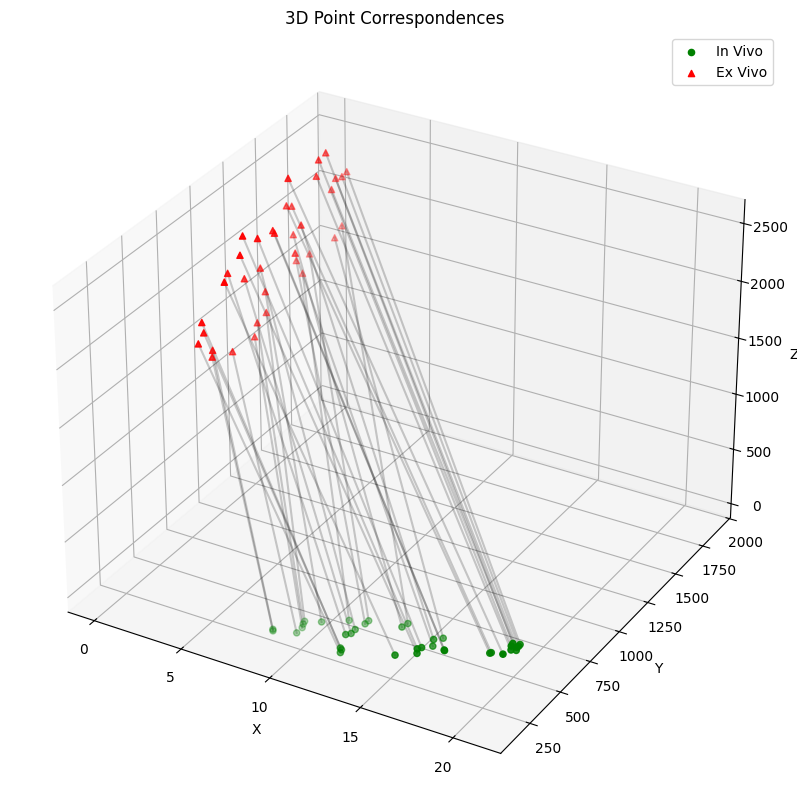

In [13]:
"""Main function with enhanced visualizations"""
print(f"Number of matched pairs: {len(in_vivo_coords)}")
print("\nInitial point correspondences:")
visualize_3D_points(in_vivo_coords, ex_vivo_coords)


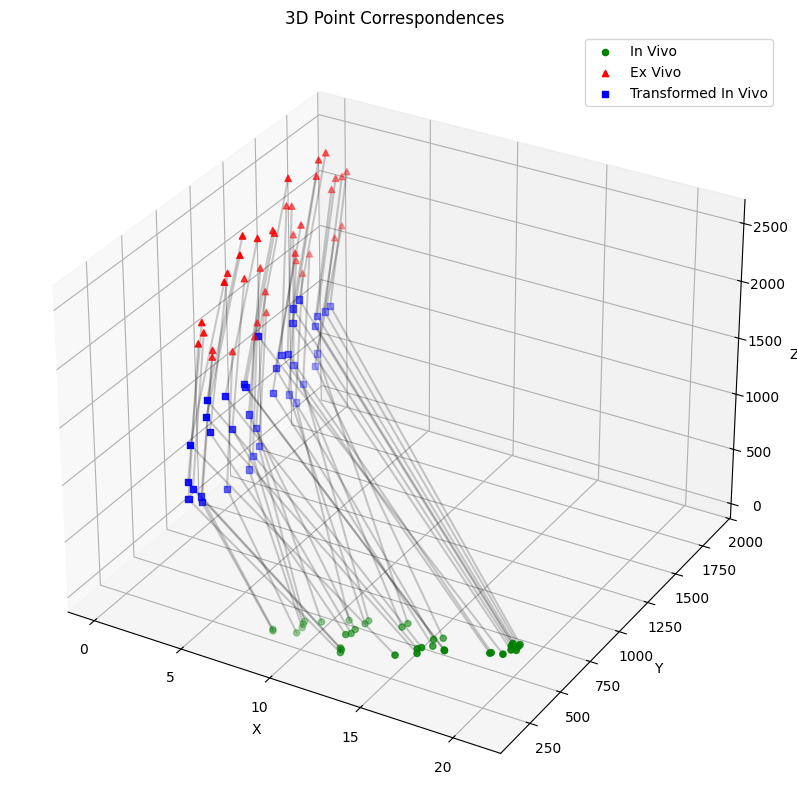

In [14]:
visualize_3D_points(in_vivo_coords, ex_vivo_coords, transformed_coords=scaled_in_vivo_coords)


In [16]:
# 没有scal
# bhat = wahba(in_vivo_coords, ex_vivo_coords)  # transforms from source to target
# scale 之后
bhat = wahba(scaled_in_vivo_coords, ex_vivo_coords)

In [17]:
print(bhat)

[[ 9.99999986e-01  4.86583829e-05 -1.62775914e-04]
 [-6.98769546e-05  9.91114615e-01 -1.33010583e-01]
 [ 1.54857507e-04  1.33010592e-01  9.91114604e-01]
 [-8.65979241e-01  1.55617836e+02  1.18351644e+03]]


In [19]:
# 没有scale
# tran, im1_wahba = run_doubleICP(invivo_image, exvivo_image, bhat, in_vivo_coords, ex_vivo_coords, max_correspondence_distance = 100)
# scale 之后
tran, im1_wahba = run_doubleICP(invivo_image, exvivo_image, bhat, scaled_in_vivo_coords, ex_vivo_coords, max_correspondence_distance = 100)

In [20]:
# ICP debug
print("ICP Transformation:")
print("Rotation part:\n", tran[:3,:3])
print("Translation part:\n", tran[:3,3])
print("Scale:", np.cbrt(np.linalg.det(tran[:3,:3])))

ICP Transformation:
Rotation part:
 [[ 9.86712582e-01 -6.52557603e-06  1.76326501e-06]
 [ 6.51863492e-06  9.86705046e-01  3.85631350e-03]
 [-1.78875509e-06 -3.85631348e-03  9.86705046e-01]]
Translation part:
 [1.21699530e-02 1.35951566e+01 2.98208458e+01]
Scale: 0.9867125815291987


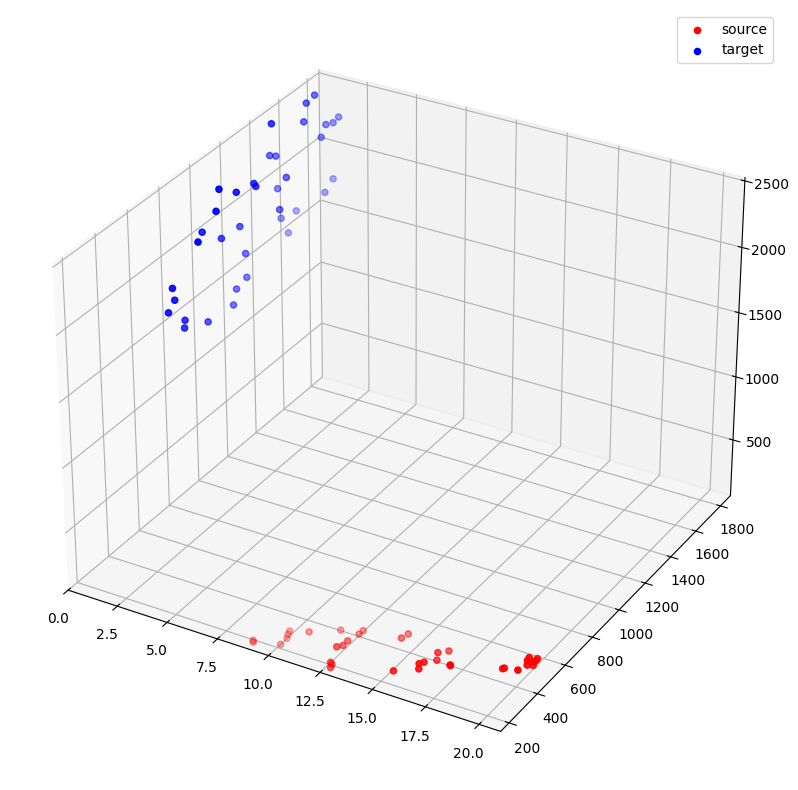

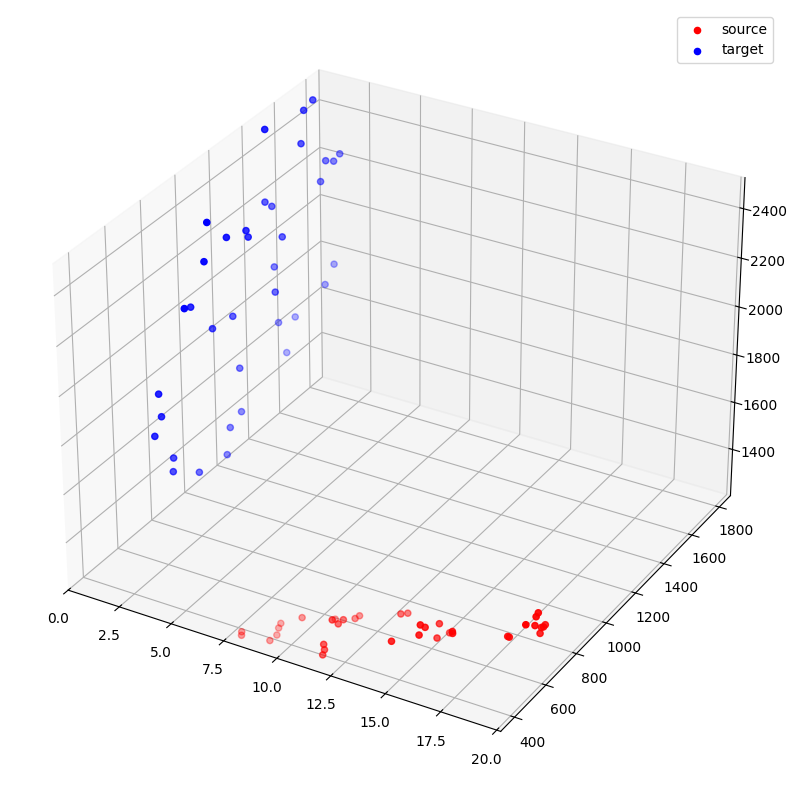

In [21]:
def visualize_point_matches(source_points, target_points):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    # 设定固定的轴范围
    x_min, x_max = min(source_points[:,0].min(), target_points[:,0].min()), max(source_points[:,0].max(), target_points[:,0].max())
    y_min, y_max = min(source_points[:,1].min(), target_points[:,1].min()), max(source_points[:,1].max(), target_points[:,1].max())
    z_min, z_max = min(source_points[:,2].min(), target_points[:,2].min()), max(source_points[:,2].max(), target_points[:,2].max())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    
    ax.scatter(source_points[:,0], source_points[:,1], source_points[:,2], c='r', label='source')
    ax.scatter(target_points[:,0], target_points[:,1], target_points[:,2], c='b', label='target')
    plt.legend()
    plt.show()

# 查看原始匹配点
visualize_point_matches(in_vivo_coords, ex_vivo_coords)

# 查看变换后的点
transformed_points = np.c_[in_vivo_coords, np.ones((in_vivo_coords.shape[0],1))] @ bhat
visualize_point_matches(transformed_points, ex_vivo_coords)

In [21]:
total_R, total_shift, total_scale = get_final_transformation(tran,bhat) 

In [22]:
# print out the final results. 
print('rotation matrix:\n',total_R)
print(f'scale:\n{total_scale}')
print('shift:\n',total_shift)
# print(f'euler (radiant):\n{rotationMatrixToEulerAngles(total_R/total_scale)}')
# print(f'euler (degree):\n{angles(rotationMatrixToEulerAngles(total_R/total_scale))}')

rotation matrix:
 [[ 1.04685633e+00  9.39038758e-04  4.44776964e-02]
 [ 6.91170119e-03  1.03141466e+00 -1.84454168e-01]
 [-4.39474192e-02  1.84581228e-01  1.03047839e+00]]
scale:
1.0478011822483428
shift:
 [  -8.27200763 1058.97978063 1711.85083778]


In [26]:
# 如果是二值图像 (segmentation)
# invivo_binary_transformed = apply_doubleICP_2_binary(invivo_seg, exvivo_seg, total_R, total_shift)

# 如果是原始图像
# invivo_transformed = apply_total_R(invivo_image, exvivo_image, total_R, total_shift)
im1_happy= apply_total_R(invivo_image, exvivo_image, bhat[:3,:3], bhat[-1])

In [30]:
img_de,z_de,ncc_list,vec_field_smooth_list = learn_and_apply_deformable(im1_happy,exvivo_image,vec_ds=2)
# img_de, z_de, ncc_list, vec_field_smooth_list = learn_and_apply_deformable(im1_wahba, exvivo_image, vec_ds)

iteration 0...


/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:35: UserWarning: Could not determine RMS error between images with the normalized average intensities 418140770.2500001 and 0.0. Either the reference or moving image may be empty.
  shift,_,_ = phase_cross_correlation(im1_t_f, im2_t_f)
/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:35: UserWarning: Could not determine RMS error between images with the normalized average intensities 508316139.56249994 and 0.0. Either the reference or moving image may be empty.
  shift,_,_ = phase_cross_correlation(im1_t_f, im2_t_f)
/scratch/jl10897/multimodal_image_registration/functions/iterive_non_rigid.py:35: UserWarning: Could not determine RMS error between images with the normalized average intensities 534533377.8437502 and 0.0. Either the reference or moving image may be empty.
  shift,_,_ = phase_cross_correlation(im1_t_f, im2_t_f)
/scratch/jl10897/multimodal_image_registration/functions/

KeyboardInterrupt: 

im1_wahba range: -201.0911 69398.99


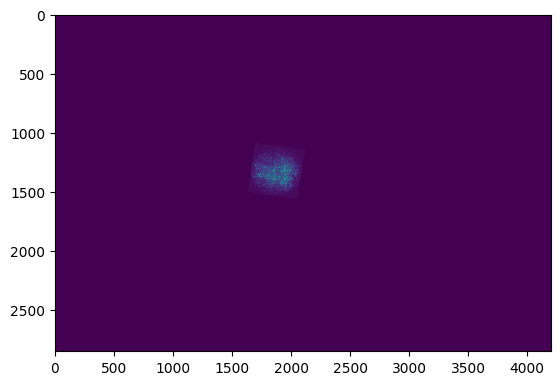

In [31]:
print("im1_wahba range:", np.min(im1_wahba), np.max(im1_wahba))
plt.imshow(np.max(im1_wahba, axis=0))  # 查看投影图像
plt.show()

In [ ]:
scl_1 = 0.1
scl_2 = 0.2
plt.figure(figsize=(23,11))
plt.subplot(1,3,1)
plt.imshow(gray2RGB(exvivo_image, col='r', scl=scl_1))
plt.subplot(1,3,2) 
plt.imshow(gray2RGB(exvivo_image, col='r', scl=scl_1) + 
         gray2RGB(img_de, col='g', scl=scl_2))
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(gray2RGB(invivo_image, col='g', scl=scl_2))
plt.yticks([])
plt.tight_layout()

In [ ]:
# 直接计算形变后图像的匹配
cc_invivo, cc_exvivo, closest_pair, invivo_cent_new = count_cell_matching(img_de, exvivo_image)